In [5]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import matplotlib.patches as mpatches

import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score 

from sklearn.tree import DecisionTreeRegressor #how methods are imported 

from sklearn import metrics #this will give us access to evaluation metrics
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

from pysr import PySRRegressor

from scipy.optimize import curve_fit

from physical_formula_spinvdisk2 import disks_physical_formula_func as phys_eqn



In [2]:
# Normalized dataset: all masses divided by halo mass (Mvir)
df_normalized_31 = pd.read_csv('Halo Mass Normalized Dataset w 31 features.csv')


In [3]:
# Remove non-physical galaxies whose Mstar/Mvir (GalpropNormMstar) > 0.2
df_normalized_31 = df_normalized_31[df_normalized_31.GalpropNormMstar < 0.2]

In [4]:
df_normalized_31.shape

(35368, 32)

In [33]:
df_imp = df_normalized_31.loc[:, ['HalopropSpin', 'GalpropNormMstar_merge', 'GalpropNormMstar',
                                  'GalpropNormVdisk', 'GalpropNormMbulge', 'GalpropNormSigmaBulge',
                                  'HalopropNormMstar_diffuse', 'GalpropMaccdot_radio',
                                   'HalopropMetal_ejected', 'GalpropZstar', 'GalpropNormMHI',
                                   'GalpropNormMcold', 'HalopropMaccdot_reaccreate', 'HalopropC_nfw',
                                   'GalpropNormMHII', 'GalpropNormHalfRadius']]

In [35]:
X_imp = df_imp.drop(columns=['GalpropNormHalfRadius'])


y_imp = df_imp.loc[:,'GalpropNormHalfRadius']

In [6]:
X = df_normalized_31.drop(columns=['GalpropNormHalfRadius'])


y = df_normalized_31.loc[:,'GalpropNormHalfRadius']

In [36]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_imp, y_imp, test_size=0.33, random_state=42)

In [8]:
X_train.shape

(23696, 31)

### Decision Tree of Train Set

In [37]:
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [63]:
regr_RF = DecisionTreeRegressor(random_state=0)

# number of trees in random forest
# n_estimators = [10, 100, 1000]
# create random grid
grid = {#'bootstrap': [True],
               'max_depth': [5],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 5, 10],
               'min_samples_split': [2, 5, 10]}
#                'n_estimators': n_estimators}
# Re-design the grid using the best params obtained from gridsearchCV on the complete dataset in notebook v19
# Best params, best score: 0.9144 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}

# Grid search of parameters
rfr_grid = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

rfr_grid.fit(X_imp, y_imp)

print('Best params, best score:', "{:.4f}".format(rfr_grid.best_score_), \
    rfr_grid.best_params_)
# define trainscore according to best model
best_RF=rfr_grid.best_estimator_ # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

best_RF_trainscore=rfr_grid.cv_results_['mean_train_score'][rfr_grid.best_index_]

# predict y (galaxy sizes) by using 5-fold cross-validation
y_pred_RF = cross_val_predict(best_RF, X_imp, y_imp, cv = KFold(n_splits=5, shuffle=True, random_state=10))

# find prediction scores of each of the cross validation fold
scores_RF = cross_val_score(best_RF, X_imp, y_imp, cv = KFold(n_splits=5, shuffle=True, random_state=10))
print("RF Accuracy: %0.2f (+/- %0.2f)" % (scores_RF.mean(), scores_RF.std() * 2))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params, best score: 0.6421 {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2}
RF Accuracy: 0.64 (+/- 0.05)


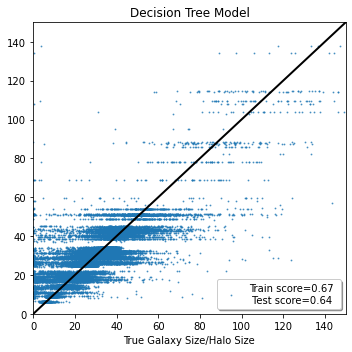

In [64]:
fig1,ax5 = plt.subplots(nrows=1,ncols=1,sharey=True, figsize=(5,5))
# fig1.suptitle('TNG-SAM Central Galaxies: Size Prediction with 31 input features', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore, 2),round(scores_RF.mean(), 2) )
im5 = ax5.scatter(y_imp, y_pred_RF, s=3, marker='.', alpha=0.7, label=label)
# ax5.set_xlim(auto=True)
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim(auto=True)
ax5.axis([0.0,150, 0.0,150])
ax5.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax5.set_title('Decision Tree Model')
ax5.set_xlabel('True Galaxy Size/Halo Size')
# ax5.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

# fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig1.tight_layout()
# fig1.savefig("TNG-SAM_DecisionTree_size_pred_15feat.jpeg", dpi=500)
plt.show()

In [112]:
#Here is a bunch of packages for visualization purposes only - this cell can be skipped if troublesome

from io import StringIO
from IPython.display import Image  
import pydotplus
from sklearn.tree import export_graphviz

# export the decision tree to a tree.dot file
# for visualizing the plot easily anywhere
dot_data = StringIO()
export_graphviz(rfr_grid.best_estimator_.fit(X_imp, y_imp), out_file = dot_data,
               feature_names = X_train.columns,   filled = True, rounded = True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
nodes = graph.get_node_list()

for node in nodes:
    if node.get_label():
        #values = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')]
        #values = [int(ii) for ii in node.get_label().split('value = ')[0]]
        #print(values)
        #values = [255 * v / sum(values) for v in values]
        value = float(node.get_label().split('value = ')[-1].split('"')[0])
        print(value)
#         values = [int(255 * v / sum(values)) for v in values]
            
#         if value[0] > value[1]:
#             alpha = int(value[0] - value[1])
#             alpha = '{:02x}'.format(alpha) #turn into hexadecimal
#             color = '#20 B2 AA'+str(alpha)
#         else:
#             alpha = int(value[1] - value[0])
#             alpha = '{:02x}'.format(alpha)
#             color = '#FF 00 FF'+str(alpha)
        node.set_fillcolor('lightblue')

graph.set_dpi('300')

Image(graph.create_png())
# Image(graph.write_png('DecisionTree_15features_maxdepth5.png'))

28.36
21.632
24.113
21.094
21.749
20.642
24.63
14.817
17.045
11.341
29.755
31.379
29.472
34.093
18.964
21.079
9.811
14.13
9.689
11.632
10.595
13.777
8.16
8.893
6.392
17.978
19.646
17.727
21.146
15.28
14.099
17.441
36.14
34.72
38.174
43.519
41.454
57.075
33.493
28.856
41.702
26.652
32.607
34.691
21.203
22.484
25.308
16.891
69.59
91.931
79.702
86.466
53.613
110.589
114.326
69.476
37.464
23.879
32.693
12.25
58.666
86.372
34.362


In [72]:
print(node.get_label())

"HalopropSpin <= 0.037\nsquared_error = 237.16\nsamples = 35368\nvalue = 28.36"


In [82]:
import sys
!{sys.executable} - m pip install graphviz

Python 3.9.7 (default, Sep 16 2021, 23:53:23) 
[Clang 12.0.0 ] :: Anaconda, Inc. on darwin
Type "help", "copyright", "credits" or "license" for more information.
>>> 
Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
KeyboardInterrupt
>>> 

In [89]:
!conda install --yes --prefix {sys.prefix} pydotplus

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.11.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /Users/festabu/miniforge3/envs/native

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pydotplus-2.0.2            |     pyhaef67bd_5          24 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          24 KB

The following NEW packages will be INSTALLED:

  pydotplus          conda-forge/noarch::pydotplus-2.0.2-pyhaef67bd_5



pydotplus-2.0.2      | 24 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [73]:
type(node.get_label())

str

In [60]:
rfr_grid.best_estimator_.fit(X_imp, y_imp)

DecisionTreeRegressor(max_features='auto', min_samples_leaf=5, random_state=0)

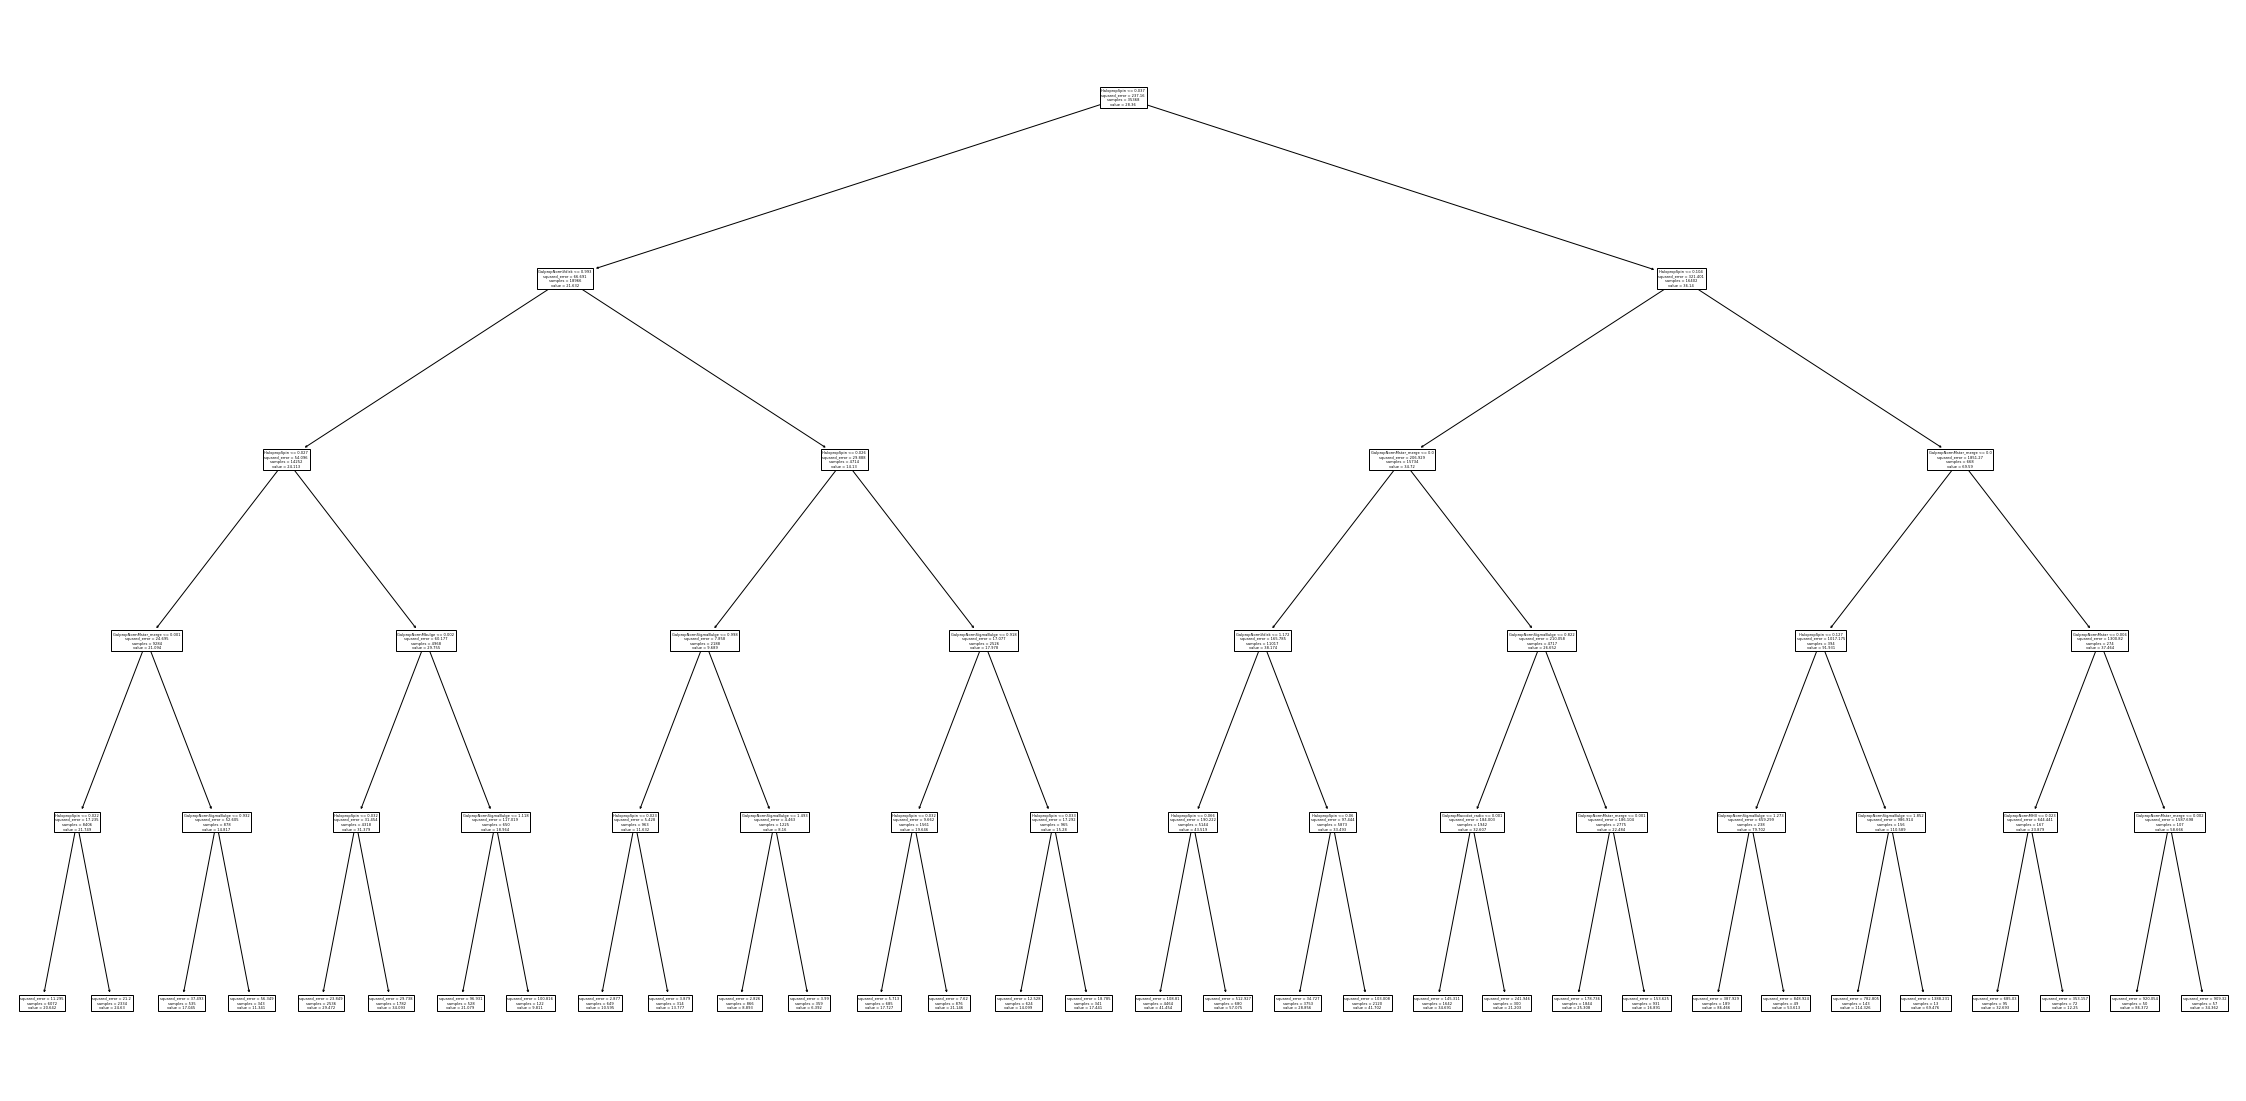

In [65]:
from sklearn import tree

plt.figure(figsize=(40,20))  # customize according to the size of your tree

tree.plot_tree(rfr_grid.best_estimator_.fit(X_imp, y_imp), feature_names = X_train.columns)

plt.show()

In [45]:
ypred = regressor.predict(X_test)

In [46]:
r2_score(y_test, ypred)

0.7657323110586585

In [47]:
regressor.fit(X_train, y_train).feature_importances_

array([0.46531784, 0.12780374, 0.07054264, 0.10280112, 0.0790365 ,
       0.05481819, 0.01284706, 0.00673069, 0.01582716, 0.00554953,
       0.02355135, 0.00348777, 0.01214175, 0.01532809, 0.00421657])